In [1]:
import os
import string
import numpy as np
import pandas as pd
import re
import nltk
import spacy
from spacy import displacy
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

nlp = spacy.load('en_core_web_lg')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Read Data

In [2]:
root_folder = r'/kaggle/input/nlp-project-fcis-23/20news-19997/20_newsgroups'
sub_folders = os.listdir(root_folder)
len(sub_folders)

20

In [3]:
sub_folders

['soc.religion.christian',
 'talk.politics.misc',
 'rec.motorcycles',
 'talk.politics.mideast',
 'sci.electronics',
 'sci.space',
 'rec.sport.baseball',
 'misc.forsale',
 'talk.politics.guns',
 'sci.med',
 'comp.sys.mac.hardware',
 'rec.sport.hockey',
 'comp.sys.ibm.pc.hardware',
 'talk.religion.misc',
 'sci.crypt',
 'comp.windows.x',
 'comp.os.ms-windows.misc',
 'rec.autos',
 'comp.graphics',
 'alt.atheism']

In [4]:
def read_data(root_folder, sub_folders):

    data, labels = [], []
    
    for folder in sub_folders:
        path = os.path.join(root_folder, folder)
        samples = os.listdir(path)

        for sample in samples:
            sample_path = os.path.join(path, sample)
            text = open(sample_path, encoding='iso-8859-1')   # 'latin-1')
            data.append(text.read())
            labels.append(folder)
    
    return data, labels

In [5]:
data, labels = read_data(root_folder, sub_folders)

print(len(data))
print(len(labels))

19997
19997


In [6]:
print(labels[1200])
print('-' * 50 , end='\n\n')
print(data[1200])

talk.politics.misc
--------------------------------------------------

Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!enterpoop.mit.edu!ai-lab!ai-lab!not-for-mail
From: Clinton-HQ@Campaign92.Org (The White House)
Newsgroups: talk.politics.misc
Subject: CLINTON: Remarks by the President: Teacher of the Year Award
Date: 20 Apr 1993 22:27:55 -0400
Organization: MIT Artificial Intelligence Lab
Lines: 98
Sender: daemon@ai.mit.edu
Message-ID: <1r2bfbINNoku@life.ai.mit.edu>
NNTP-Posting-Host: life.ai.mit.edu






                           THE WHITE HOUSE

                    Office of the Press Secretary

______________________________________________________________
For Immediate Release                             April 20, 1993     

                       REMARKS BY THE PRESIDENT
           DURING PRESENTATION OF TEACHER OF THE YEAR AWARD
	     
                           The R

### Some Visualization Methods

talk.politics.misc


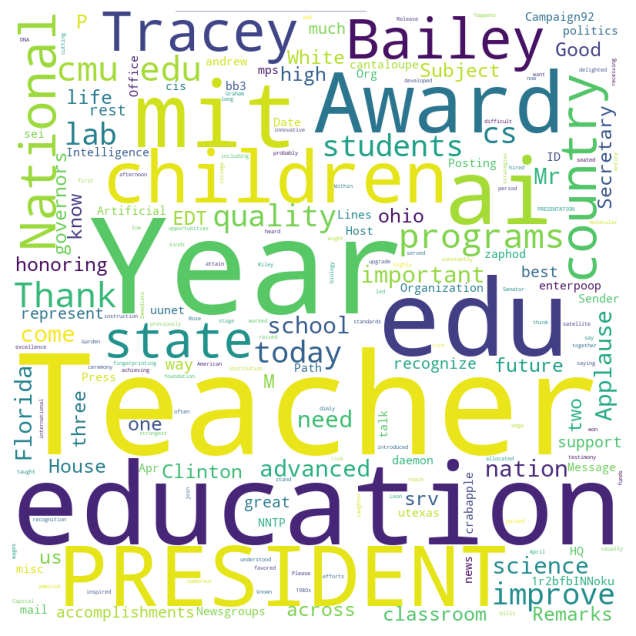

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print(labels[1200])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(data[1200])

# Display the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [8]:
print(labels[1200])
print('-' * 50 , end='\n\n')
displacy.render(nlp(data[1200]), style = "ent",jupyter = True)

talk.politics.misc
--------------------------------------------------



In [9]:
# displacy.render(nlp(data[1200]), style = "dep",jupyter = True, options={'distance': 80,})
# displacy.render(nlp(data[1200]), style="dep", options={"compact": True, "bg": "#09a3d5",
#                                            'distance': 80,"color": "white",
#                                            "font": "Source Sans Pro"})

### Clean Header

In [10]:
def clean_header(text):
    text = re.sub(r'(From:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Subject:[^\n]+\n)', '', text)
    text = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', text)
    text = re.sub(r'(Last-modified:[^\n]+\n)', '', text)
    text = re.sub(r'(Version:[^\n]+\n)', '', text)

    return text

### Clean Text

In [11]:
re_url = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
re_email = re.compile('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')                 

def clean_text(text):        
    text = text.lower()
    text = text.strip()
    text = re.sub(re_url, '', text)
    text = re.sub(re_email, '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'(\d+)', ' ', text)
    text = re.sub(r'(\s+)', ' ', text)
    
    return text

In [12]:
for i in range(len(data)):
    data[i] = clean_text(clean_header(data[i]))

### Tokenaization & Remove Stopwords
- stopwords tokens can be removed from a Doc object by creating a new Doc object without the unwanted tokens.

- You can remove tokens by converting doc to numpy array, removing from numpy array and then converting back to doc.

In [13]:
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, LEMMA
from spacy.tokens import Doc

def remove_stopwords(doc):
    indexes = []
    for index, token in enumerate(doc):
        if token.is_stop:
            indexes.append(index)
    np_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA, LEMMA])
    np_array = np.delete(np_array, indexes, axis = 0)
    doc2 = Doc(doc.vocab, words=[t.text for i, t in enumerate(doc) if i not in indexes])
    doc2.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA, LEMMA], np_array)
    return doc2

In [14]:
Docs = []
for i in range(len(data)):
    Docs.append(remove_stopwords(nlp(data[i])))
    if i%1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


### Lemmatization

In [15]:
str(Docs[0])

'xref cantaloupesrvcscmuedu socreligionchristian path cantaloupesrvcscmuedumagnesiumclubcccmuedueddiemitedueuropaenggtefsdcomhowlandrestonansnetusccsutexasedurutgersigorrutgerseduathosrutgerseduchristian newsgroups socreligionchristian messageid date gmt sender replyto organization sun microsystems inc lines approved eugen bigelow writes noteworthy consider jesus attitude argument pharisees ot canon john explained followers road emmaus law prophets psalms referred ot division scripture luke luke taking genesis chronicles jewish order genesis malachi scripture remember adams transgression men women sinned paul wrote humanity cooperativley reblled god admas sin subject sin transmitted generation generation andy byler andy write paragraph believe rd time elses words attributed nt speak rest humanity cooperatively rebell '

In [16]:
lemmas_ = ' '.join(token.lemma_ for token in Docs[0])
lemmas_

'xref cantaloupesrvcscmuedu socreligionchristian path cantaloupesrvcscmuedumagnesiumclubcccmuedueddiemitedueuropaenggtefsdcomhowlandrestonansnetusccsutexasedurutgersigorrutgerseduathosrutgerseduchristian newsgroups socreligionchristian messageid date gmt sender replyto organization sun microsystems inc line approve eugen bigelow write noteworthy consider jesus attitude argument pharisees ot canon john explain follower road emmaus law prophet psalm refer ot division scripture luke luke take genesis chronicle jewish order genesis malachi scripture remember adams transgression man woman sin paul write humanity cooperativley reblled god admas sin subject sin transmit generation generation andy byler andy write paragraph believe rd time else word attribute not speak rest humanity cooperatively rebell'

In [17]:
final_data = []
for i in range(len(Docs)):
    lemmas_ = ' '.join(token.lemma_ for token in Docs[i])
    final_data.append(lemmas_)
    if i%1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


### TF-IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word', max_features=5000)
vectors = vectorizer.fit_transform(final_data)

In [19]:
vectors.shape

(19997, 5000)

In [20]:
vectors.data

array([0.09114855, 0.08568315, 0.0356839 , ..., 0.00489418, 0.00583104,
       0.00978836])

### Split Data

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(vectors, encoded_labels, test_size=0.3, stratify=labels, shuffle=True)

In [23]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(13997, 5000)
(6000, 5000)
(13997,)
(6000,)


## Name of labels

In [24]:
names = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc']

# RandomForest ---> Best Till Now

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42,)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [26]:
y_pred = rf.predict(X_val)
print(y_pred[:24])
print(y_val[:24])

[ 7  2  7 14  8  1 12 14 16  0 16  1  7 14 14 19  1  3 19  9 16  4 10 11]
[ 7  2  7 14  8  1 12 14 16 19 16  1  7 14 14 19  1  3 19  9 16  4 10 11]


(<Figure size 1200x500 with 1 Axes>,
 <AxesSubplot: xlabel='predicted label', ylabel='true label'>)

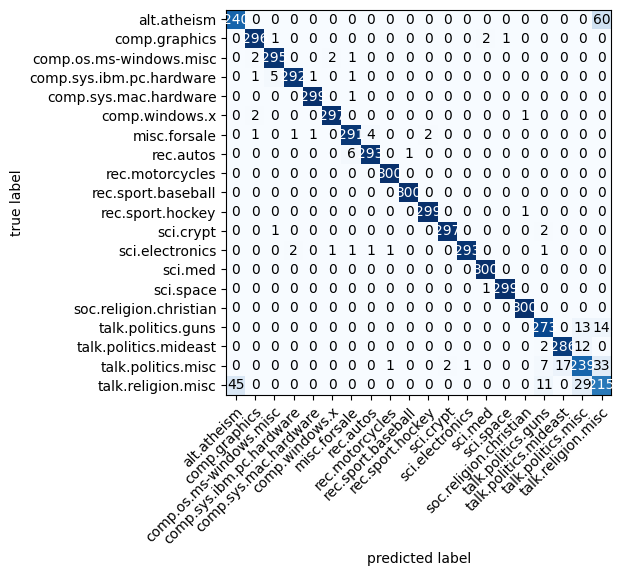

In [27]:
cm = confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cm,class_names=names,figsize=(12,5))

In [28]:
print(f"Train Accuracy: {rf.score(X_train, y_train)*100:.3f}%")
print(f"Test Accuracy: {rf.score(X_val, y_val)*100:.3f}%")

Train Accuracy: 98.035%
Test Accuracy: 95.067%


In [37]:
import pandas as pd
import pickle
pickle.dump(rf, open('RandomForestModel.pkl', 'wb'))

# DecisionTreeClassifier 

In [40]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()

In [41]:
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [42]:
train_score_dt = dt.score(X_train,y_train)

In [43]:
test_score_dt = dt.score(X_val,y_val)

In [44]:
ytest_pred_dt = dt.predict(X_val)

(<Figure size 1200x500 with 1 Axes>,
 <AxesSubplot: xlabel='predicted label', ylabel='true label'>)

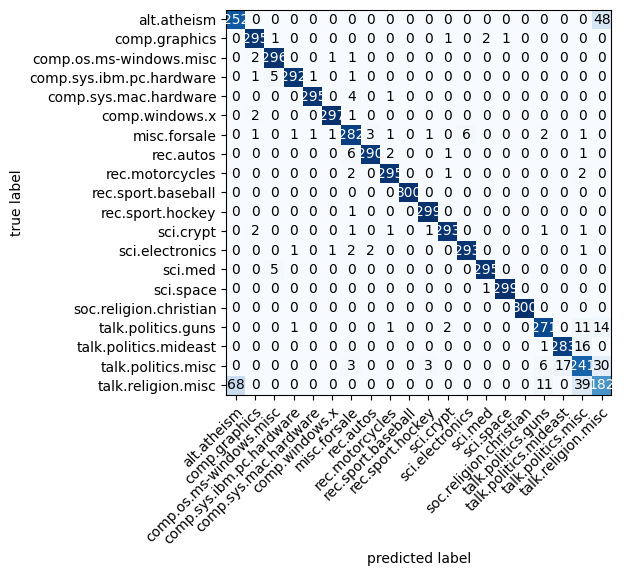

In [45]:
conf_mat_dt =confusion_matrix(y_val,ytest_pred_dt)
plot_confusion_matrix(conf_mat_dt,class_names=names,figsize=(12,5))

In [46]:
print(f"Train Accuracy: {train_score_dt*100:.3f}%")
print(f"Test Accuracy: {test_score_dt*100:.3f}%")

Train Accuracy: 98.035%
Test Accuracy: 94.167%


# XGB Classifier

In [47]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective= 'binary:RandomForest', learning_rate=0.04, n_estimators = 200)

In [48]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [49]:
train_score_xgb = xgb.score(X_train,y_train)

In [50]:
test_score_xgb = xgb.score(X_val,y_val)

In [51]:
ytest_pred_xgb = xgb.predict(X_val)

(<Figure size 1200x500 with 1 Axes>,
 <AxesSubplot: xlabel='predicted label', ylabel='true label'>)

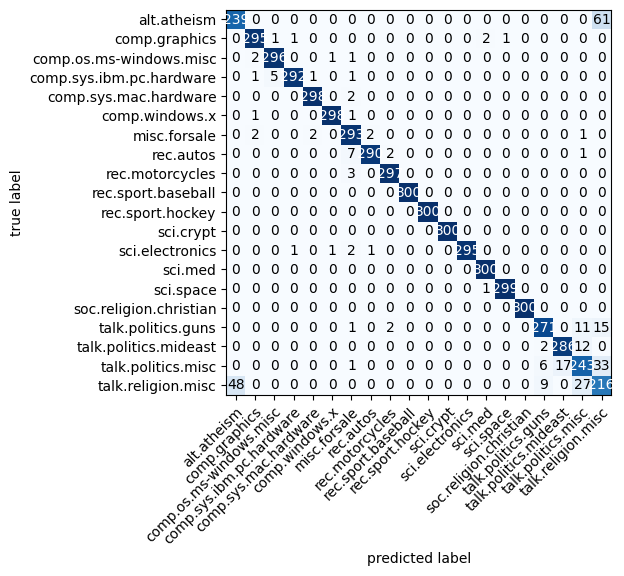

In [52]:
conf_mat_xgb =confusion_matrix(y_val,ytest_pred_xgb)
plot_confusion_matrix(conf_mat_xgb,class_names=names,figsize=(12,5))

In [53]:
print(f"Train Accuracy: {train_score_xgb*100:.3f}%")
print(f"Test Accuracy: {test_score_xgb*100:.3f}%")

Train Accuracy: 98.035%
Test Accuracy: 95.133%


In [54]:
pickle.dump(xgb, open('XGBClassifierModel.pkl', 'wb'))

# AdaBoost Classifier 

In [55]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(learning_rate=0.02, n_estimators=100,estimator=RandomForestClassifier())

In [ ]:
abc.fit(X_train,y_train)

In [ ]:
train_score_abc = abc.score(X_train,y_train)

In [ ]:
test_score_abc = abc.score(X_val,y_val)

In [ ]:
ytest_pred_abc = abc.predict(X_val)

In [ ]:
conf_mat_abc =confusion_matrix(y_val,ytest_pred_abc)
plot_confusion_matrix(conf_mat_abc,class_names=names,figsize=(12,5))

In [ ]:
print(f"Train Accuracy: {train_score_abc*100:.3f}%")
print(f"Test Accuracy: {test_score_abc*100:.3f}%")

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
ytrain_pred_knn = knn.predict(X_train)

In [ ]:
ytest_pred_knn = knn.predict(X_val)

In [ ]:
ytrain_score_knn = knn.score(X_train,y_train)


In [ ]:
ytest_score_knn = knn.score(X_val,y_val)


In [ ]:
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

In [ ]:
conf_mat_knn =confusion_matrix(y_val,ytest_pred_knn)

In [ ]:
plot_confusion_matrix(conf_mat_knn,class_names=names,figsize=(12,5))

In [ ]:
print(f"Train Accuracy: {ytrain_score_knn*100:.3f}%")
print(f"Test Accuracy: {ytest_score_knn*100:.3f}%")